# Hyperparameter Tuning

This notebook works in tandem with the updated training script `nf_train.py`. The input of the training script has been changed to allow flexibility in the changing various hyperparameters and detailed performance recording in JSON. These JSON files hold all of the nessacry run information and can be used to configure inferernce or further training. 

The explore the space of the parameter set this notebook contains a set of functions to generate all the possible combinations of a user given set of parameters.

In [1]:
import pandas as pd
import sys
sys.path.append('..')
import os
root_dir = os.path.split(os.getcwd())[0]
search_path = os.path.join(root_dir, 'tuning','test')
print(search_path)



d:\Black-Holes-Population-Studies\tuning\test


### Timed 20 min runtime per method.

Deciding which configuration is the most useful practically is dependent on the speed to train not just the final loss. Therefore in this approach all methods were trained for the same length of time.  

In this tune there are 12 20min trainings, with a total training time of 4 hours

In [2]:
from tools.tuning import run_combinations

params = {}
params['blocks'] = [20] #[10, 20, 30] 
params['hidden'] = [128] #, 200]
params['A'] = ['relu'] #['tanh','relu'] #activation function
params['N'] = [1500] #number of epochs
print(search_path)
results, best_path  = run_combinations(params, outdir=search_path, time=False)

d:\Black-Holes-Population-Studies\tuning\test
There are  1  combinations in this search
[{'blocks': 20, 'hidden': 128, 'A': 'relu', 'N': 1500, 'outdir': 'd:\\Black-Holes-Population-Studies\\tuning\\test'}]
num_cond_inputs =  2 , num_inputs = 2
Using cpu , Early stopping is on., DataLoader is off.
Training set: 1 simulation, each with 17783 events and each event with 2 parameters
Validation set: 1 simulation, each with 4446 events and each event with 2 parameters


100%|██████████| 2000/2000 [44:04<00:00,  1.32s/it]

{'sample_cols': ['Mass_0', 'q'], 'pop_cols': ['Z', 'alpha'], 'epochs': 2000, 'A': 'relu', 'blocks': 20, 'hidden': 128, 'label': 'blocks_20_hidden_128_A_relu_N_1500', 'early_stop': True, 'time': False, 'device': 'cpu', 'dataloader': False, 'batch_size': 150000, 'workers': 1, 'PIN_MEM': True, 'training_file': 'D:/Black-Holes-Population-Studies/notebooks\\train.pq', 'validation_file': 'D:/Black-Holes-Population-Studies/notebooks\\valid.pq', 'outdir': 'd:\\Black-Holes-Population-Studies\\tuning\\test', 'N': 1500, 'num_cond_inputs': 2, 'num_inputs': 2, 'd_score_rate': [-0.44224873396729003, 0.0199635253188877, 0.1332370478360592, -0.11399231748528668, -0.03585289412859036, -0.14304834774490247, -0.12849281770174598, 0.005995068413194756, 0.015273389394550774, -0.02361037559879557, -0.017407143230862503, -0.008976348534362993, -0.058100427752941664, -0.04900613307913983, -0.011265581713464581, -0.016813907096038756, -0.033250976956620173, 0.004383800887520709, 0.010370882263061485, -0.010002

### Automitically load the best model

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
def plot_loss(json_path, existing_ax = False, label = False):
    if type(json_path) == 'dict':
        run_info = json_path
    else:
        from tools.tuning import get_run
        run_info = get_run(json_path)
    lb =''
    if label is not False: lb=label
    if existing_ax is not False:
        ax = existing_ax
    else:
        fig, ax = plt.subplots(figsize = (15,5))
        
    train_loss = np.load(run_info['loss_path'])['train_loss.npy']
    valid_loss = np.load(run_info['loss_path'])['valid_loss.npy']

    print(np.min(train_loss), np.min(valid_loss))
    epoch= np.arange(start= 1, stop =train_loss.size+1)
    df_loss=pd.DataFrame(data=np.column_stack([epoch,train_loss, valid_loss])
                        , columns=['epoch','train_loss','valid_loss'])                   
    sns.lineplot(data=df_loss, x='epoch', y='valid_loss', label=f'Validation {lb}', ax=ax)
    sns.lineplot(data=df_loss, x='epoch', y='train_loss', label=f'Training {lb}',ax =ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend() 

In [9]:
from tools.tuning import get_results_table
search_path = os.path.join(root_dir,'tuning','test')

params = {}
params['blocks'] = [5, 10, 20, 30] 
params['hidden'] = [128, 200]
params['A'] = ['tanh','relu'] #activation function
params['N'] = [100] #number of epochs

results=get_results_table(search_path, params)


UnboundLocalError: local variable 'run_small' referenced before assignment

In [10]:
from tools.tuning import get_matches
matches= get_matches(search_path, {'epochs' : 1}, criteria = '>')
matches

['d:\\Black-Holes-Population-Studies\\tuning\\test\\blocks_20_hidden_128_A_relu_N_1500.json']

In [11]:
from tools.tuning import get_run
i=0
for m in matches: 
    m_run = get_run(m)
    print(m)
    if 'V2' in m:
        continue
    #train_loss = np.load('tuning\20mins\blocks_10_hidden_128_A_relu_N_1000_loss.npz')
    #valid_loss = np.load('tuning\20mins\blocks_10_hidden_128_A_relu_N_1000_loss.npz')
    train_loss = np.load(m_run['loss_path'])['train_loss.npy']
    valid_loss = np.load(m_run['loss_path'])['valid_loss.npy']

    epoch= np.arange(start= 1, stop =train_loss.size+1)
    
    df_loss=pd.DataFrame(data=np.column_stack([epoch,train_loss, valid_loss])
                        , columns=['epoch','train_loss','valid_loss'])
    df_loss['run'] = m_run['label'] 

    if i==0:
        df_all_loss=df_loss    
    else:
        df_all_loss=pd.concat([df_all_loss, df_loss])
    i+=1

df_all_loss

d:\Black-Holes-Population-Studies\tuning\test\blocks_20_hidden_128_A_relu_N_1500.json


,epoch,train_loss,valid_loss,run
0,1.0,5.764650,4.479600,blocks_20_hidden_128_A_relu_N_1500
1,2.0,4.490213,4.017062,blocks_20_hidden_128_A_relu_N_1500
2,3.0,4.038435,4.047508,blocks_20_hidden_128_A_relu_N_1500
3,4.0,4.067933,4.183126,blocks_20_hidden_128_A_relu_N_1500
4,5.0,4.202673,4.039795,blocks_20_hidden_128_A_relu_N_1500
...,...,...,...,...
1995,1996.0,3.175377,3.165195,blocks_20_hidden_128_A_relu_N_1500
1996,1997.0,3.147774,3.177898,blocks_20_hidden_128_A_relu_N_1500
1997,1998.0,3.166801,3.172294,blocks_20_hidden_128_A_relu_N_1500
1998,1999.0,3.162723,3.166225,blocks_20_hidden_128_A_relu_N_1500


## Loss

#### Training Loss

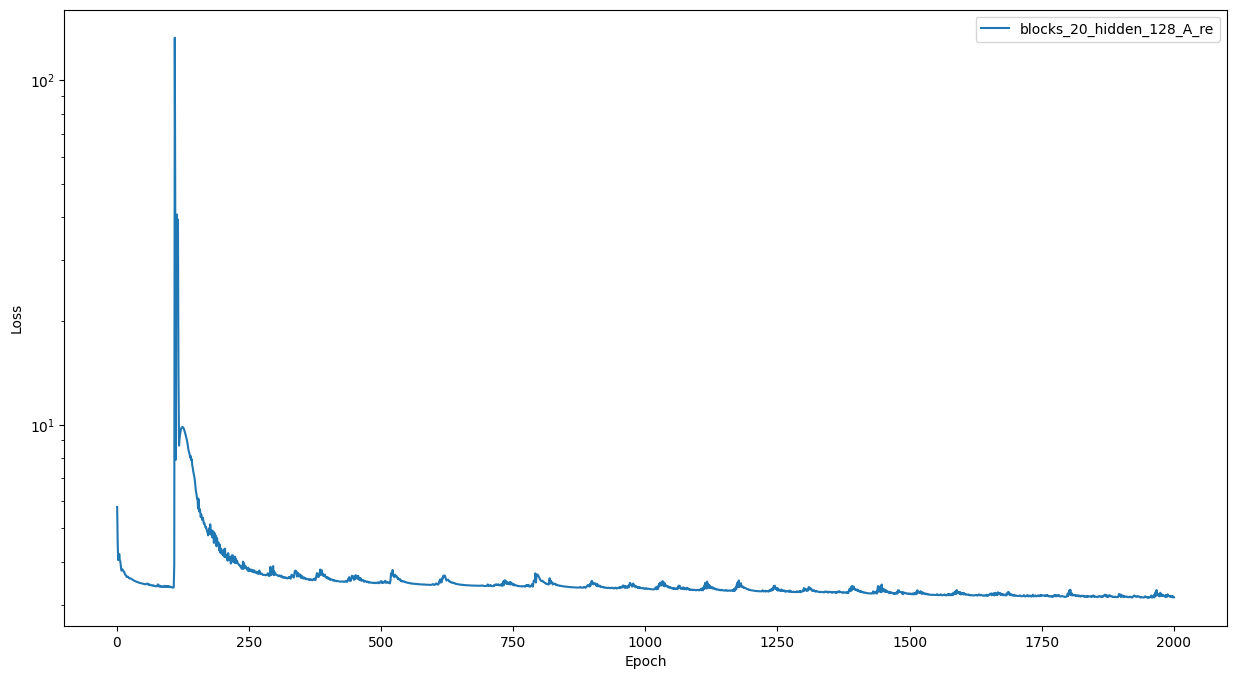

In [12]:
import seaborn as sns
plt.figure(figsize=(15,8))
df_loss=df_all_loss[df_all_loss['valid_loss']!=np.inf]
runs = df_loss['run'].unique()
for r in runs:
    df_r=df_loss[df_loss['run']==r]
    plt.plot(df_r['epoch'],df_r['train_loss'], label=r[:-9])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.legend(ncols=3)
plt.yscale('log')


#### Validation Loss

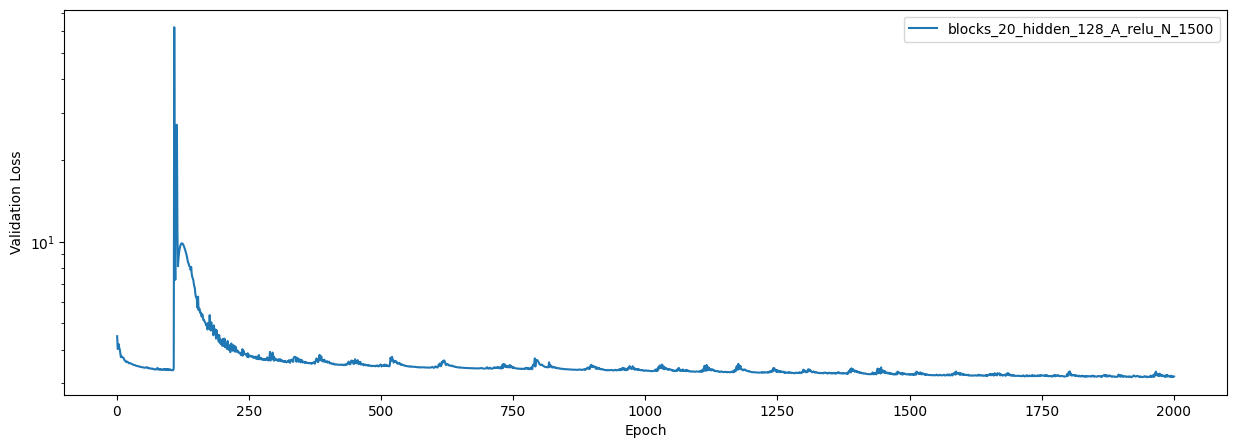

In [13]:
#sns.lineplot(hue='run',data=df_all_loss, x='epoch', y='valid_loss')
plt.figure(figsize = (15,5))
for col in df_all_loss['run'].unique():
    sns.lineplot(data=df_all_loss[df_all_loss['run']==col], x='epoch', y='valid_loss', label = col)

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.yscale('log')
plt.legend(ncol=2)

### Automatic selection of the best run 

In [14]:
from tools.tuning import get_best_run

from pprint import pprint
print(search_path)
best_run = get_best_run(search_path)

pprint(best_run)

d:\Black-Holes-Population-Studies\tuning\test
d:\Black-Holes-Population-Studies\tuning\test\blocks_20_hidden_128_A_relu_N_1500.json: Missing 'log' key
New best run found: Loss = 3.159358501434326
{'sample_cols': ['Mass_0', 'q'], 'pop_cols': ['Z', 'alpha'], 'epochs': 2000, 'A': 'relu', 'blocks': 20, 'hidden': 128, 'label': 'blocks_20_hidden_128_A_relu_N_1500', 'early_stop': True, 'time': False, 'device': 'cpu', 'dataloader': False, 'batch_size': 150000, 'workers': 1, 'PIN_MEM': True, 'training_file': 'D:/Black-Holes-Population-Studies/notebooks\\train.pq', 'validation_file': 'D:/Black-Holes-Population-Studies/notebooks\\valid.pq', 'outdir': 'd:\\Black-Holes-Population-Studies\\tuning\\test', 'N': 1500, 'num_cond_inputs': 2, 'num_inputs': 2, 'd_score_rate': [-0.44224873396729003, 0.0199635253188877, 0.1332370478360592, -0.11399231748528668, -0.03585289412859036, -0.14304834774490247, -0.12849281770174598, 0.005995068413194756, 0.015273389394550774, -0.02361037559879557, -0.01740714323086

3.1400914 3.1593585


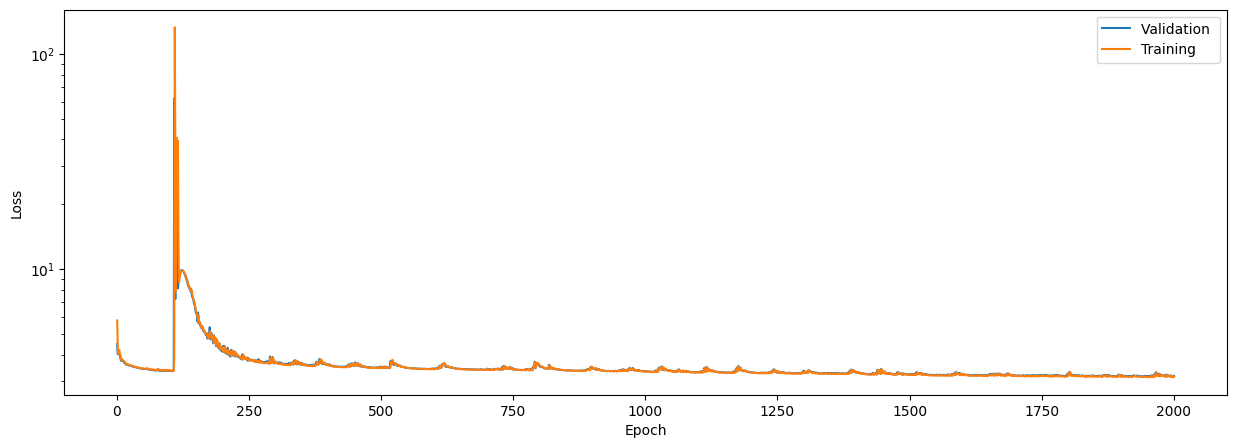

In [15]:
from tools.plotting import plot_loss
plot_loss(best_run)
plt.yscale('log')

In [11]:
import sys
sys.path.append('..')
import os
from tools.constants import root_dir, data_dir
from tools.tuning import run_combinations
params = {'N': [1000], 'blocks' : [20]}
outdir = os.path.join(root_dir, 'tuning', 'N1000')
results, json_path = run_combinations(params, outdir=outdir)


There are  1  combinations in this search
[{'N': 1000, 'blocks': 20, 'outdir': 'D:/Black-Holes-Population-Studies\\tuning\\N1000'}]
num_cond_inputs =  2 , num_inputs = 2
Using cpu , Early stopping is on., DataLoader is off.
Training set: 1 simulation, each with 101768 events and each event with 2 parameters
Validation set: 1 simulation, each with 25442 events and each event with 2 parameters


 60%|██████    | 3/5 [00:27<00:18,  9.25s/it]


KeyboardInterrupt: 